In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn import set_config
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import shap
from scipy.spatial import ConvexHull
set_config(transform_output="pandas")
import matplotlib.pyplot as plt
import contextlib 
import joblib
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
import matplotlib.colors as mcolors
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import PolynomialFeatures
from sklearn import set_config
import os
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK, SparkTrials

In [53]:
trials = pd.read_pickle('C:\\Users\\Tom\\Documents\\Bel PhD\\bel-simulation\\trials_5.pkl')
results = pd.DataFrame(trials.vals)
results['loss'] = trials.losses()

C:\Users\Tom\AppData\Local\Temp\ipykernel_12040\2456102090.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  results.hist(bins=20, ax=ax);


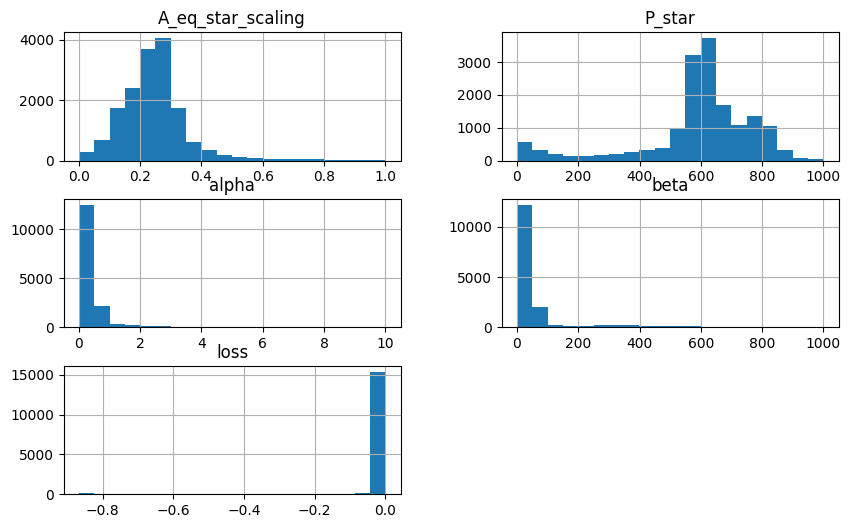

In [54]:
fig, ax = plt.subplots(figsize=(10, 6))
results.hist(bins=20, ax=ax);

In [45]:
results[results.loss < -0.5].sort_values('loss')

,A_eq_star_scaling,P_star,alpha,beta,loss
9629,0.231546,606.208615,0.002777,0.935941,-0.866873
11571,0.239280,621.182186,0.002062,0.839834,-0.865464
12307,0.289663,589.812694,0.001578,0.272731,-0.862342
11731,0.268857,625.173312,0.002310,0.843903,-0.862116
10173,0.184025,589.286657,0.002750,0.543093,-0.861228
...,...,...,...,...,...
11431,0.235165,632.464980,0.000821,0.424623,-0.505078
12270,0.253358,592.506750,0.002042,0.259713,-0.501270
9718,0.223584,589.021342,0.002276,0.503270,-0.501088
9341,0.272404,513.838766,0.001061,0.669364,-0.500582


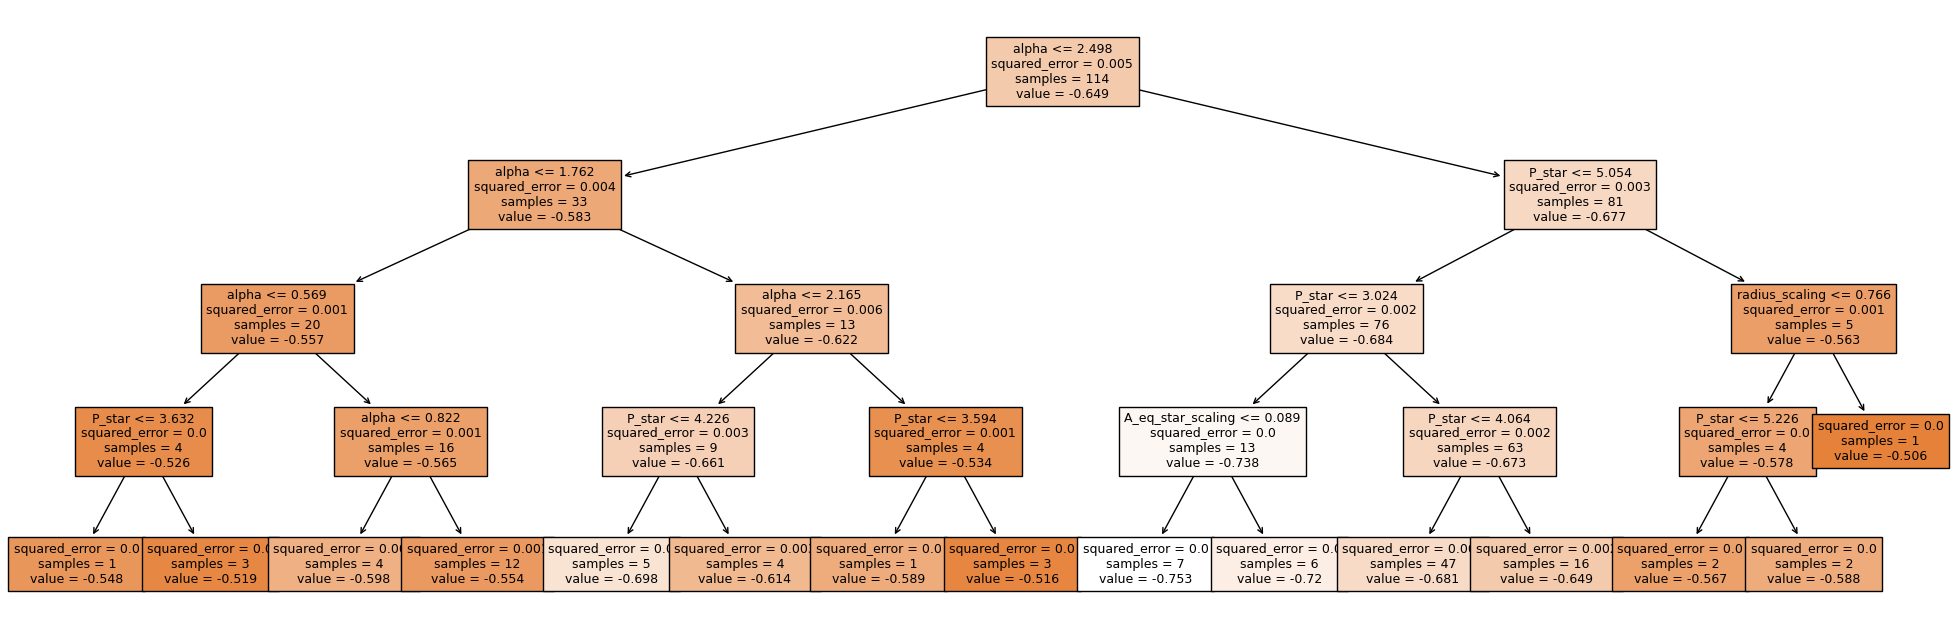

In [104]:
clf = DecisionTreeRegressor(max_depth=4)
X, y = good_results[['alpha', 'beta', 'P_star', 'A_eq_star_scaling', 'radius_scaling']], good_results.loss
clf.fit(X, y)
fig, ax = plt.subplots(figsize=(25, 8))
plot_tree(clf, filled=True, feature_names=X.columns,  ax=ax, fontsize=9);

In [107]:
from simulation import Simulation

ModuleNotFoundError: No module named 'simulation'

In [106]:
simulation = Simulation(N_bodies=10)
simulation.execute(
    alpha=4.220201,
    beta=232.088979,
    A_eq_star_scaling=0.079723,
    P_star=3.797371,
    radius_scaling=0.687362,
    write_path='F:\\Bel_Simulation\\outputs_8',
    write_results=True
)

# results = simulation.results.iloc[-1]
# target = -derive_target(
#     results['mean_separation'],
#     results['cluster_vol'],
#     results['sphericity'],
#     results['final_N_bodies'],
#     results['t']
# )

NameError: name 'Simulation' is not defined

In [99]:
good_results.corr()

,A_eq_star_scaling,P_star,alpha,beta,radius_scaling,loss
A_eq_star_scaling,1.000000,-0.212647,0.057941,-0.125285,-0.019139,-0.042637
P_star,-0.212647,1.000000,-0.197927,-0.188791,0.285984,0.487673
alpha,0.057941,-0.197927,1.000000,0.315288,-0.228190,-0.478045
beta,-0.125285,-0.188791,0.315288,1.000000,-0.172402,-0.177598
radius_scaling,-0.019139,0.285984,-0.228190,-0.172402,1.000000,0.332025
loss,-0.042637,0.487673,-0.478045,-0.177598,0.332025,1.000000


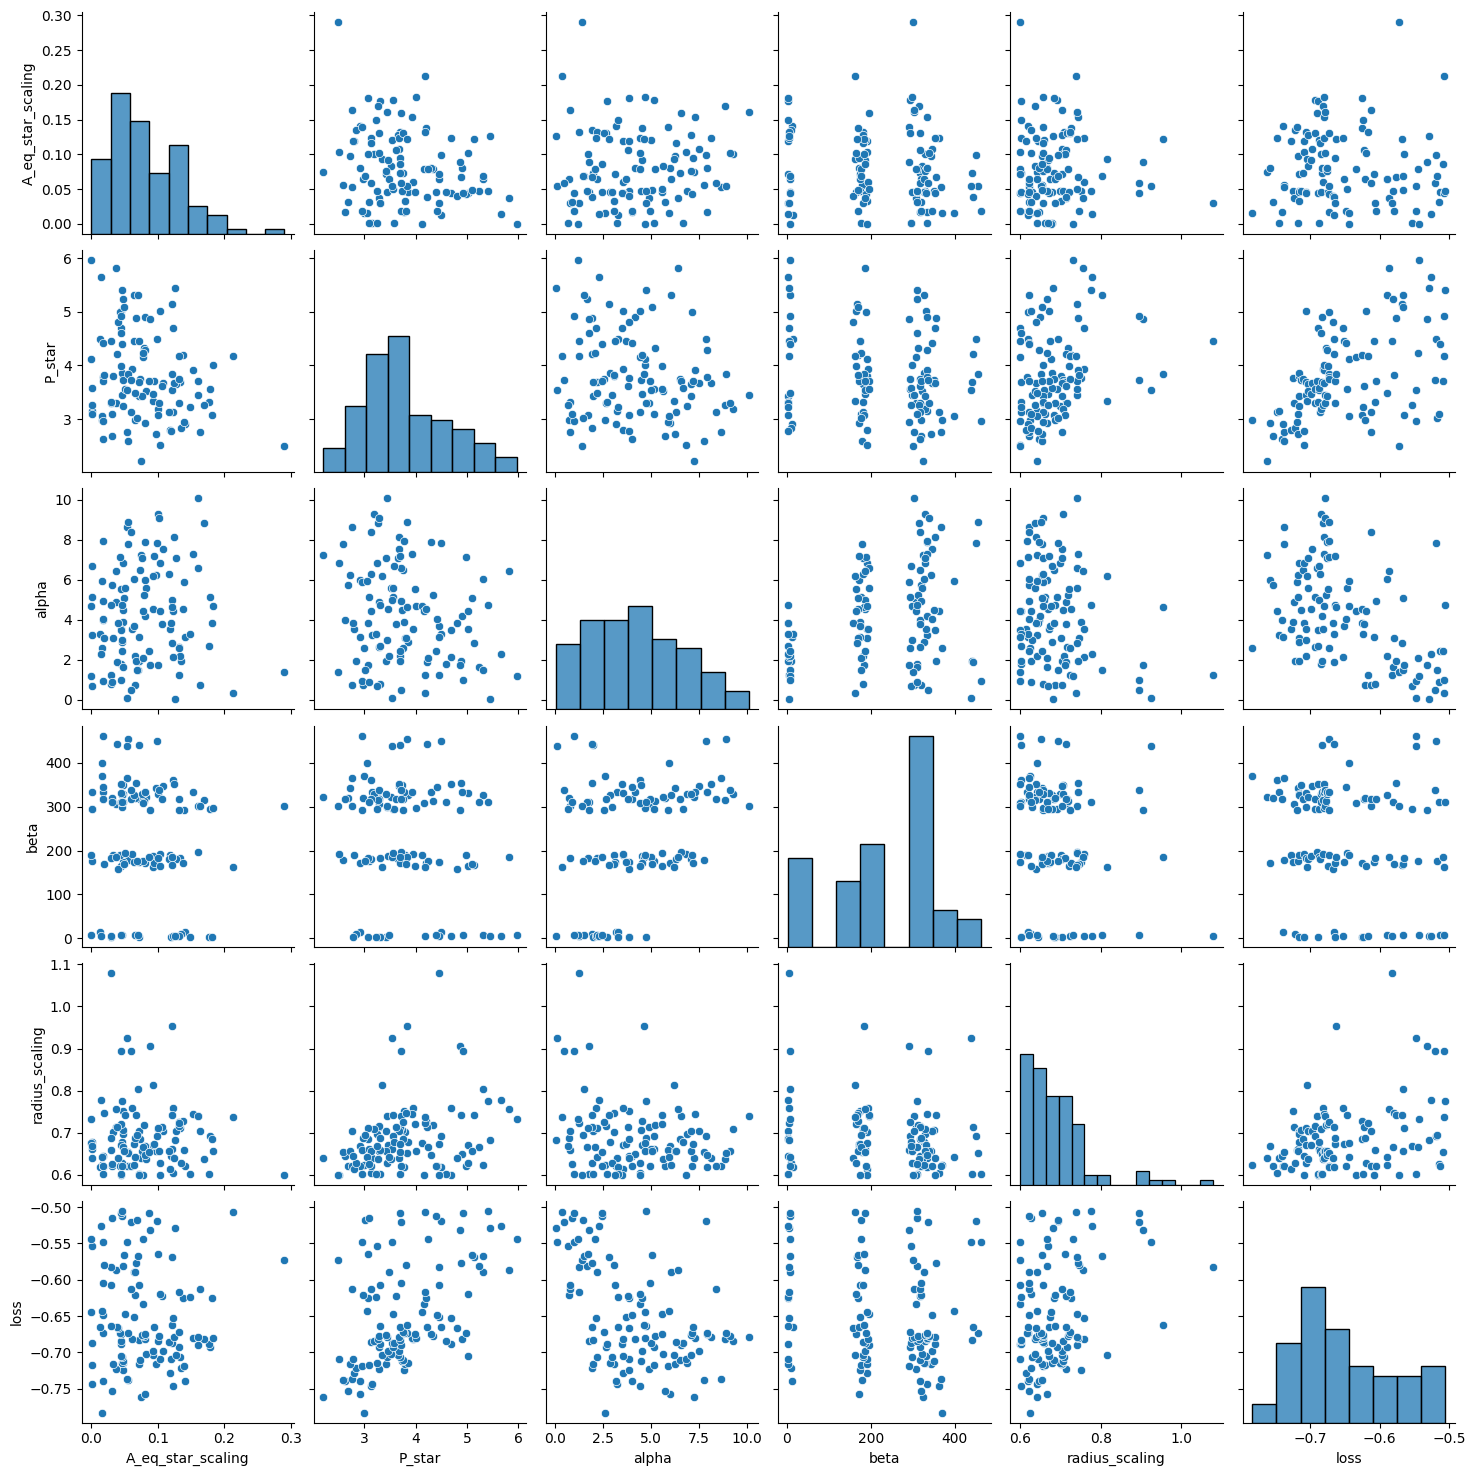

In [100]:
sns.pairplot(good_results.sort_values('loss', ascending=True))

In [2]:
set_config(transform_output="pandas")

In [3]:
mycol = ["red", "darkorange", "yellow", "limegreen", "dodgerblue", "deeppurple", "darkpink"]
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", ["dodgerblue", "limegreen"])

In [4]:
@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

In [5]:
def extract_files(folder, substring):
    files = [os.path.join(folder, x) for x in os.listdir(folder)]
    files = [x for x in files if substring.lower() in x.lower()]
    return files

folders_containing_outputs = [f"F:\\Bel_Simulation\\outputs_{x}" for x in range(1, 7)]
run_files = sum([extract_files(x, 'run') for x in folders_containing_outputs], [])
ages_files = sum([extract_files(x, 'ages') for x in folders_containing_outputs], [])
positions_files = sum([extract_files(x, 'positions') for x in folders_containing_outputs], [])


def extract_files(folder, substring):
    files = [os.path.join(folder, x) for x in os.listdir(folder)]
    files = [x for x in files if substring.lower() in x.lower()]
    return files

def create_dataframe(files, column_name):
    df = pd.DataFrame(files, columns=[column_name])
    df['folder'] = df[column_name].apply(lambda x: x.split('\\')[-2])
    df['run'] = df[column_name].apply(lambda x: x.split('\\')[-1].split('_')[-1].split('.')[0]).apply(lambda x: [x for x in x if x.isdigit()]).apply(lambda x: ''.join(x)).astype(int)
    return df

folders_containing_outputs = [f"F:\\Bel_Simulation\\outputs_{x}" for x in range(1, 7)]
run_files = sum([extract_files(x, 'run') for x in folders_containing_outputs], [])
ages_files = sum([extract_files(x, 'ages') for x in folders_containing_outputs], [])
positions_files = sum([extract_files(x, 'positions') for x in folders_containing_outputs], [])

run_files = create_dataframe(run_files, 'run_files')
ages_files = create_dataframe(ages_files, 'ages_files')
positions_files = create_dataframe(positions_files, 'positions_files')

run_files = run_files.merge(ages_files, on=['folder', 'run'], how='inner')
run_files = run_files.merge(positions_files, on=['folder', 'run'], how='inner')
run_files.drop(columns=['folder', 'run'], inplace=True)

run_files_chunks = np.array_split(run_files, 24)

c:\Users\Tom\anaconda3\envs\bel_simulation\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [9]:
def find_params(run, ages, positions):
    try:
        final_params = pd.read_parquet(run).tail(1)
        final_ages = np.load(ages, allow_pickle=True)[-1]    
        N_cells = final_ages.shape[0]
        final_params["N_cells"] = N_cells

        final_positions = np.load(positions, allow_pickle=True)[-1] 
        hull = ConvexHull(final_positions)
        final_params["Volume"] = hull.volume
        return final_params
    except:
        return pd.DataFrame()

def get_params(data):
    params = []
    for index, row in data.iterrows():
        parameters = find_params(row['run_files'], row['ages_files'], row['positions_files'])
        parameters['folder'] = row['run_files'].split("\\")[2]
        params.append(parameters)
    return pd.concat(params)


In [11]:
with tqdm_joblib(tqdm(desc="My Simulation", total=len(run_files_chunks))) as progress_bar:
    final_props = Parallel(n_jobs=-1)(delayed(get_params)(chunk) for chunk in run_files_chunks)

My Simulation:   0%|          | 0/24 [00:00<?, ?it/s]

In [12]:
output = pd.concat(final_props)

In [50]:
output = output[output.Cluster_Vol <= 5000]

In [13]:
output.groupby('end_reason', dropna=False)[['alpha', 'beta', 'P_star', 'A_eq_star_scaling', 'lumen_volume_scaling', 'lumen_radius_scaling']].mean()

,alpha,beta,P_star,A_eq_star_scaling,lumen_volume_scaling,lumen_radius_scaling
end_reason,,,,,,
unknown_uncaught,2.733982,3.027977,10.985715,0.116253,0.253086,0.894605
unphysical_area,0.597332,3.763424,12.157424,0.245607,0.250337,0.885132
unphysical_hull,0.277631,1.449818,5.715035,0.085342,0.257574,0.897659
NaN,0.008365,1.148187,6.937061,0.074465,0.224211,0.800952


In [54]:
#sns.scatterplot(data=output[(output.end_reason.isna())], x='lumen_radius_scaling', y='Cluster_Vol', palette="hsv", hue="alpha", legend="full")

In [52]:
output.groupby('end_reason', dropna=False).size()

end_reason
unknown_uncaught    3583
unphysical_area     8154
unphysical_hull     7467
NaN                 1012
dtype: int64

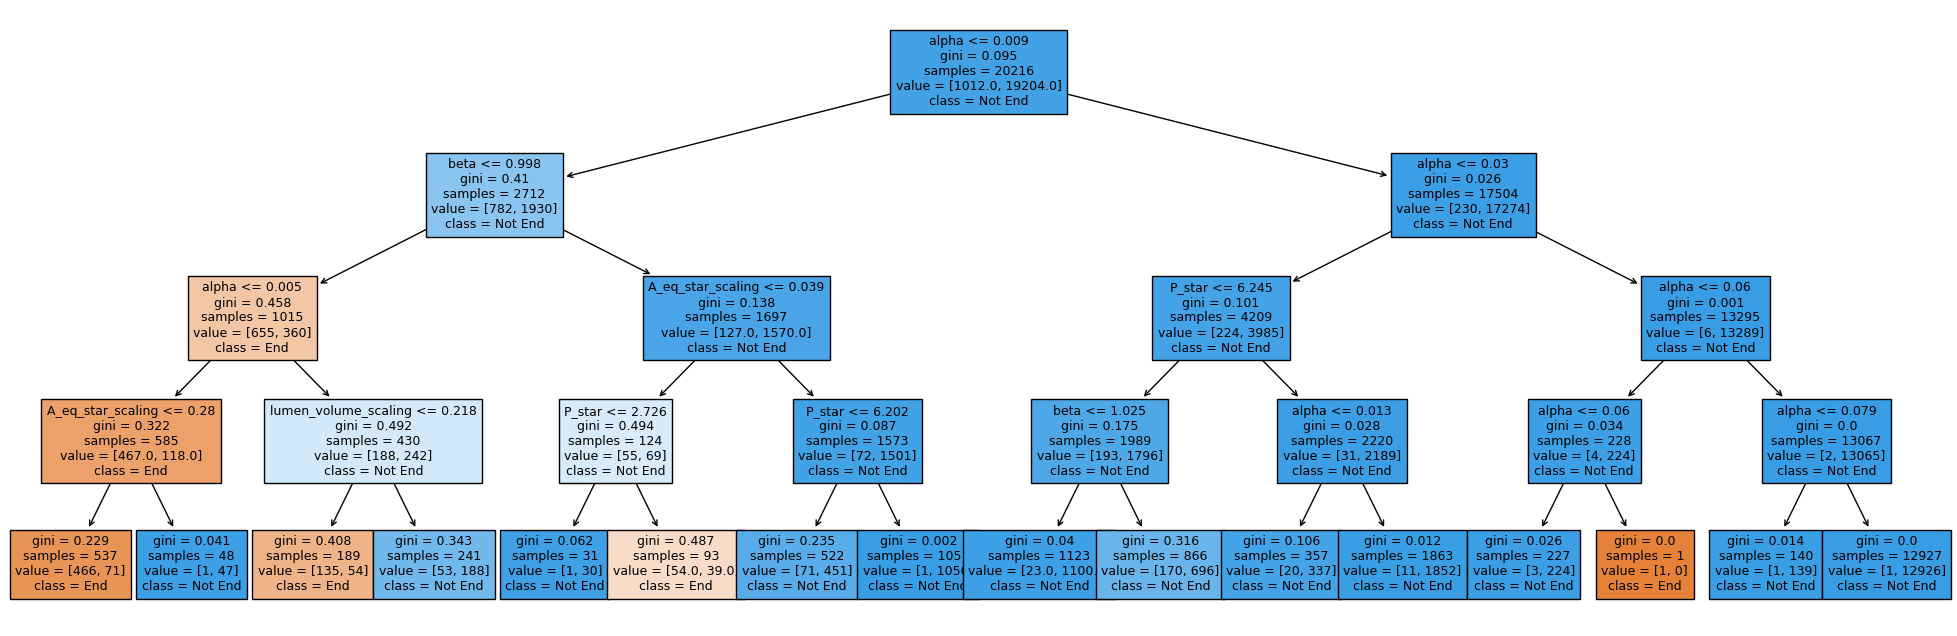

In [53]:
clf = DecisionTreeClassifier(max_depth=4)
X, y = output[['alpha', 'beta', 'P_star', 'A_eq_star_scaling', 'lumen_volume_scaling', 'lumen_radius_scaling']], output.end_reason
y.fillna(1, inplace=True)
y = y.apply(lambda x: 1 if x != 1 else 0)
clf.fit(X, y)
fig, ax = plt.subplots(figsize=(25, 8))
plot_tree(clf, filled=True, feature_names=X.columns, class_names=['End', 'Not End'], ax=ax, fontsize=9);

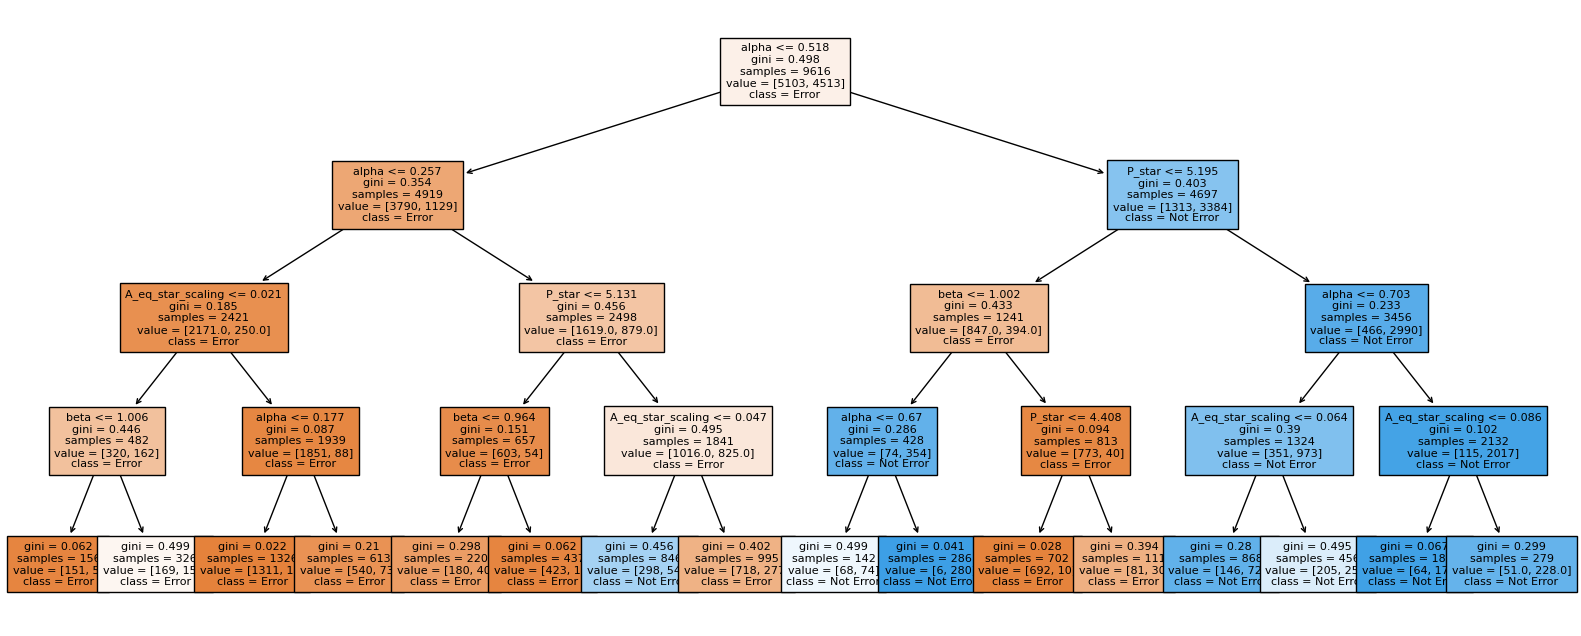

In [49]:
clf = DecisionTreeClassifier(max_depth=4, min_samples_leaf=10)
X, y = output[['alpha', 'beta', 'P_star', 'A_eq_star_scaling', 'lumen_volume_scaling', 'lumen_radius_scaling']], output.end_reason
y = y.apply(lambda x: 1 if x == 'unknown_uncaught' else 0)
clf.fit(X, y)
fig, ax = plt.subplots(figsize=(20, 8))
plot_tree(clf, filled=True, feature_names=X.columns, class_names=['Error', 'Not Error'], ax=ax, fontsize=8, );

In [34]:
output[(output.Cluster_Vol <= 1000) & (output.end_reason.isna())].sort_values('Cluster_Vol')

,t,Cluster_Vol,Areas,Preferred_area,Lumen_volume,Run_No,r_min,beta,alpha,A_eq_star_scaling,P_star,mean_lifetime,lumen_volume_scaling,lumen_radius_scaling,end_reason
120441,20.0,0.030606,0.397497,0.051516,65.005768,2420,1,0.539619,0.011338,0.129602,11.349254,5,0.353700,0.553665,None
120632,20.0,0.031383,1.721715,0.111487,9.180335,704,1,0.179099,0.009631,0.064754,1.210129,5,0.013890,0.777078,None
120546,20.0,0.040177,0.847065,0.037102,68.721775,697,1,0.101782,0.012052,0.043801,13.058065,5,0.297672,0.542752,None
120368,20.0,0.082998,0.375333,0.052233,8.970585,3263,1,0.127971,0.023843,0.139163,7.142896,5,0.013012,0.566103,None
120777,20.0,0.124724,2.127938,0.316666,69.377138,1773,1,0.257299,0.008399,0.148814,4.124730,5,0.216875,0.565978,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121435,20.0,958.257833,6.665833,0.838423,9.686388,3177,1,2.322160,0.008153,0.125779,3.925447,5,0.027927,0.770117,None
121396,20.0,963.342801,5.723786,0.170942,74.615412,1030,1,1.999793,0.029757,0.029865,3.715010,5,0.389499,0.710679,None
121330,20.0,974.074837,5.626653,0.245239,7.122214,683,1,1.028622,0.010421,0.043585,3.595416,5,0.269845,0.725879,None
121534,20.0,997.219811,5.341784,0.502077,5.869294,796,1,2.359432,0.015553,0.093991,3.230138,5,0.023766,0.521786,None


In [64]:
output['density'] = output.N_cells / output.Cluster_Vol

In [65]:
output[(output.end_reason == 1) & (output.density > 10) & (output.density < 14)]

,t,Cluster_Vol,Areas,Preferred_area,Lumen_volume,Run_No,r_min,beta,alpha,A_eq_star_scaling,P_star,mean_lifetime,lumen_volume_scaling,lumen_radius_scaling,end_reason,N_cells,Volume,density
120401,20.0,0.510765,1.308972,0.048081,16.167708,2243,1,0.844358,0.016371,0.036732,16.133549,5,0.063242,0.735305,1,6,0.510765,11.747088
120401,20.0,0.607343,1.404424,0.205069,10.766244,2694,1,0.692323,0.015135,0.146016,1.541219,5,0.037350,0.958391,1,7,0.607343,11.525605
120803,20.0,0.961484,0.824243,0.086088,26.015852,1250,1,0.620650,0.009976,0.104445,0.704221,5,0.083599,0.622220,1,13,0.961484,13.520765
120553,20.0,0.475659,1.425025,0.189864,33.452812,139,1,0.630130,0.008957,0.133235,6.715131,5,0.122515,0.759656,1,6,0.475659,12.614087
121027,20.0,1.664563,0.414604,0.009981,19.846215,2112,1,0.859293,0.009486,0.024073,2.484994,5,0.042022,0.568206,1,19,1.664563,11.414409
120625,20.0,0.876628,0.823815,0.050483,10.377376,341,1,0.988469,0.009256,0.061280,3.970743,5,0.010024,0.733438,1,10,0.876628,11.407343
121330,20.0,8.291584,0.343636,0.025547,8.317000,542,1,0.569069,0.006284,0.074343,4.797368,5,0.003798,0.551154,1,91,8.291584,10.974984
120401,20.0,0.373259,4.149397,0.604380,39.386998,651,1,0.766118,0.014497,0.145655,4.555551,5,0.188951,0.700371,1,5,0.373259,13.395512
121225,20.0,2.517078,0.456452,0.032829,9.509236,882,1,0.949512,0.008615,0.071922,2.471120,5,0.014707,0.608801,1,33,2.517078,13.110439
120533,20.0,0.426934,3.786372,0.755075,19.338517,939,1,0.500876,0.008587,0.199419,4.149329,5,0.072986,0.824866,1,5,0.426934,11.711415


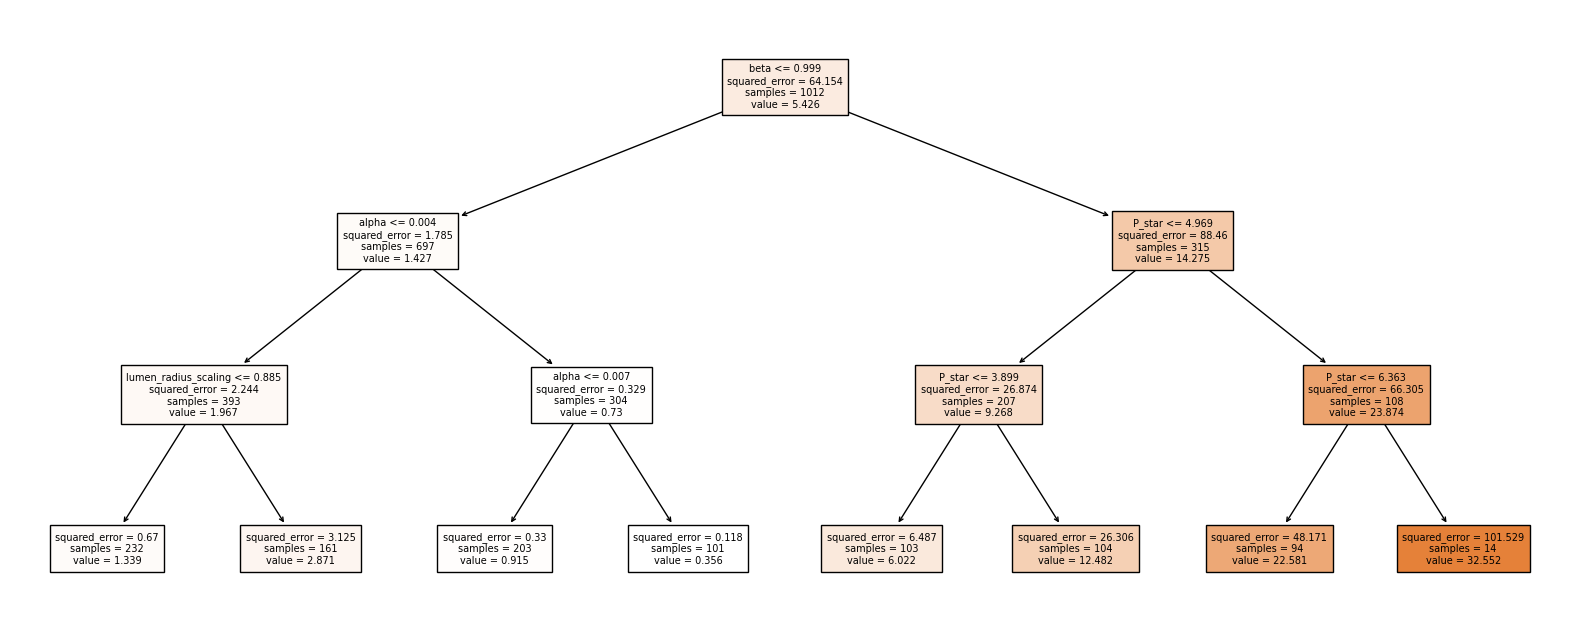

In [63]:
clf = DecisionTreeRegressor(max_depth=3, min_samples_leaf=10)
X, y = output[output.end_reason == 1][['alpha', 'beta', 'P_star', 'A_eq_star_scaling', 'lumen_volume_scaling', 'lumen_radius_scaling']], output[output.end_reason == 1].Cluster_Vol / output[output.end_reason == 1].N_cells
clf.fit(X, y)
fig, ax = plt.subplots(figsize=(20, 8))
plot_tree(clf, filled=True, feature_names=X.columns, ax=ax, fontsize=7, );

In [115]:
#data = pd.read_csv("final_morphological_params_including_N_and_sphericity.csv")##old, didn't alter lumen formation. Poss issue with a eq
#data = pd.read_csv("full_param_space_2811.csv").reset_index()
# data = pd.read_csv("all_params_0901.csv").reset_index()
# 
data = output
data.head
# data = data[data["N_cells"]>7]
# data = data[data["Cluster_Vol"] < 5000]
# data = data[data["Cluster_Vol"]>5]
test = data[data["t"]==20]
test[["Cluster_Vol", "Areas", "Lumen_volume", "Run_No", "N_cells"]]
test.shape

(59, 17)

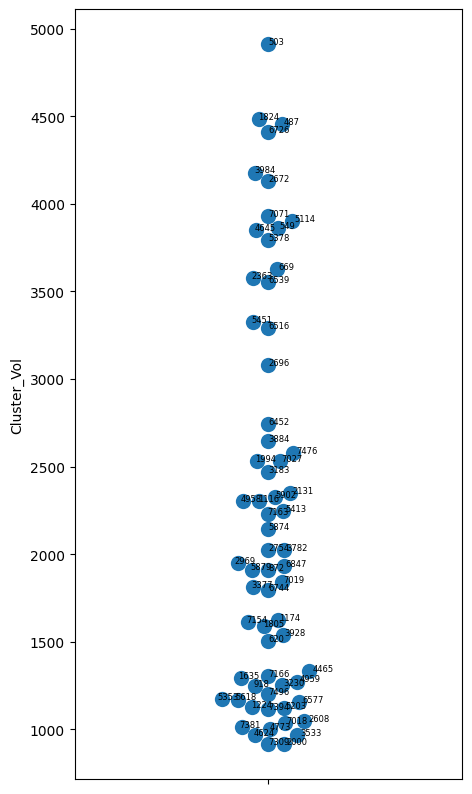

In [15]:
data_to_plot = data[data["Cluster_Vol"]>900]
fig, ax = plt.subplots(figsize=(5,10))
sns.swarmplot(data = data_to_plot, y="Cluster_Vol", ax=ax, size=11)
my_offsets = ax.collections[0].get_offsets()
for offset in my_offsets:
    if offset[0] <0:
        offset = offset -0.4
    else:
        offset = offset + 0.4

# Annotating each point with its index
for i, run in enumerate(data_to_plot["Run_No"]):
    ax.text(x=10*my_offsets[i][0], y=data_to_plot[data_to_plot["Run_No"] == run]["Cluster_Vol"], s=str(run), color="black", fontsize=6)

In [30]:
data["Areas"] = data["Areas"]/ data["Preferred_area"] # area now represents the proprtional difference from the equilibrium

In [57]:
def plot_shap_custom(output_param, X, y, check_additivity = False):
    # Train the model
    model = RandomForestRegressor(max_depth=6, n_jobs=-1, n_estimators=500, max_features=0.33)
    model.fit(X, y[output_param])
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X, check_additivity = check_additivity)
    feature_names = X.columns
    shap_df = pd.DataFrame(shap_values, columns=feature_names)
    feature_df = pd.DataFrame(X, columns=feature_names)
    shap_df['instance'] = range(len(shap_df))
    shap_values = explainer.shap_values(X, check_additivity=check_additivity)
    shap.summary_plot(shap_values, X, plot_size=(7,5), show=False, max_display=10, 
                      plot_type='dot', feature_names=X.columns, cmap=cmap)
    plt.title("{} Important Params".format(output_param.replace("_", " ")))
    ax= plt.gca()
    plt.show()

#############Individual Params
    fig, axs = plt.subplots(nrows=len(feature_names), figsize=(6, 3*len(feature_names)))
    print("all feature names", feature_names)
    for i, feature in enumerate(feature_names):
        axs[i].scatter(feature_df[feature], shap_df[feature], alpha=0.5, color="dodgerblue")
        axs[i].set_xlabel("{} value".format(nice_string_format(feature)))
        axs[i].set_ylabel("SHAP value (impact on model output)")
        axs[i].set_title("{}'s impact on {}".format(nice_string_format(feature), nice_string_format(output_param)))
    plt.tight_layout()
    plt.show()

def nice_string_format(str):
    return  str.replace("beta", r"$\beta$").replace("A_eq_star_scaling",  r"$A'^\star_{scaling}$").replace("N_cells", r"$N_{cells}$").replace("lumen_radius_scaling", r"$r_l$").replace("lumen_volume_scaling", r"$V_l$")
    

# No Interactions

In [54]:
successful_output = output[output.end_reason == 1]

In [55]:
X, y = successful_output[["beta", "A_eq_star_scaling","lumen_radius_scaling", "P_star", "lumen_volume_scaling"]], successful_output[['Cluster_Vol', 'Areas', 't', "Lumen_volume", 'N_cells']].rename(columns={'t': 't_max'})

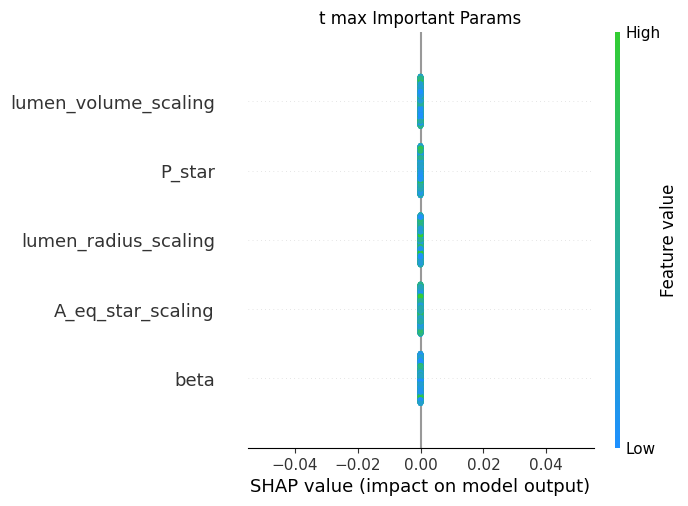

all feature names Index(['beta', 'A_eq_star_scaling', 'lumen_radius_scaling', 'P_star',
       'lumen_volume_scaling'],
      dtype='object')


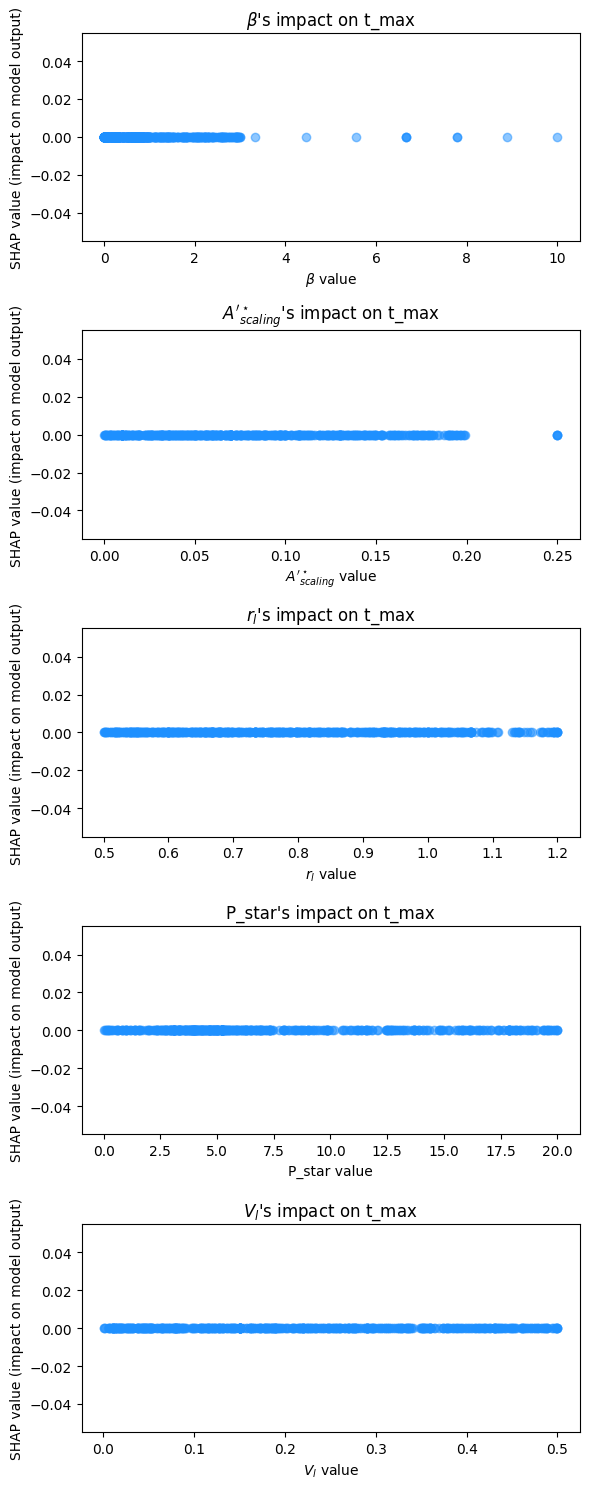

In [68]:
plot_shap_custom("t_max", X, y)

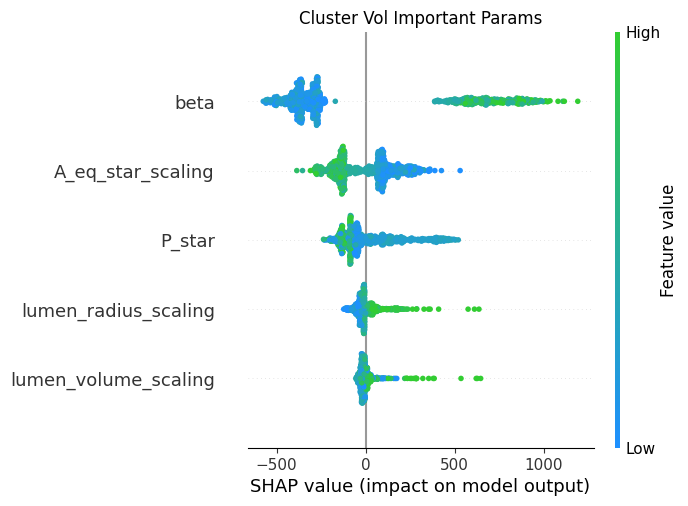

all feature names Index(['beta', 'A_eq_star_scaling', 'lumen_radius_scaling', 'P_star',
       'lumen_volume_scaling'],
      dtype='object')


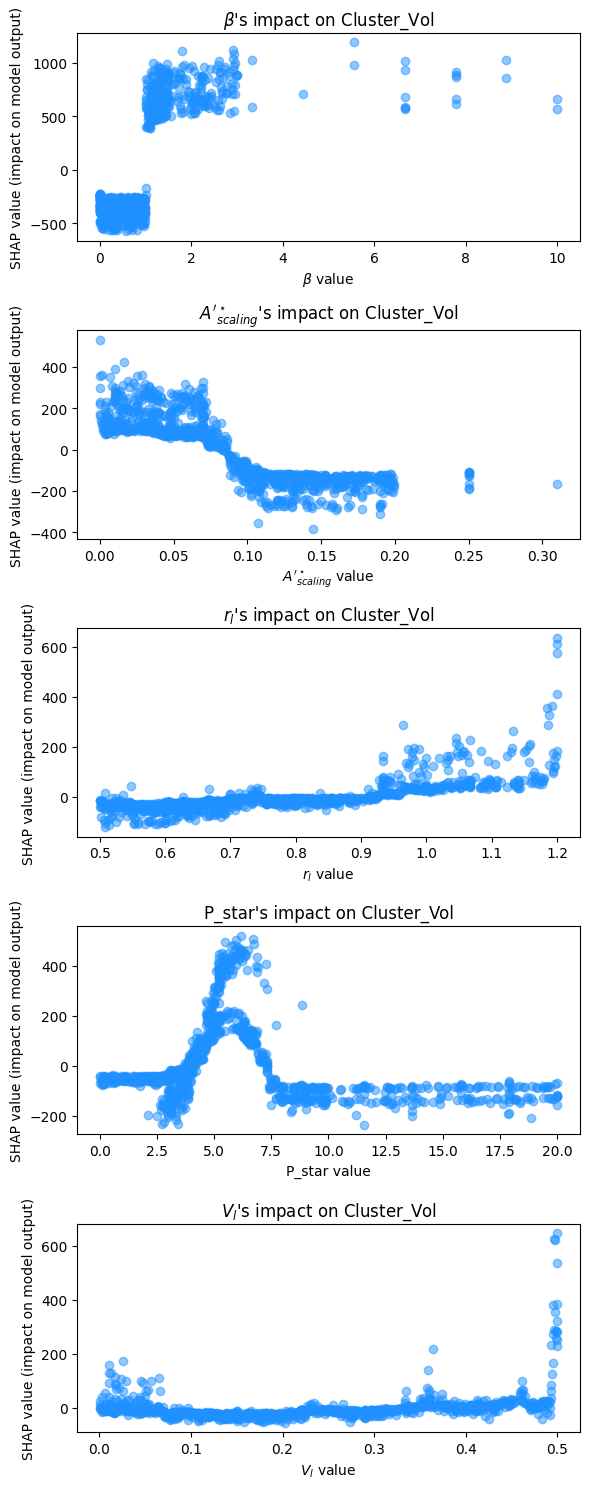

In [58]:
plot_shap_custom("Cluster_Vol", X, y)

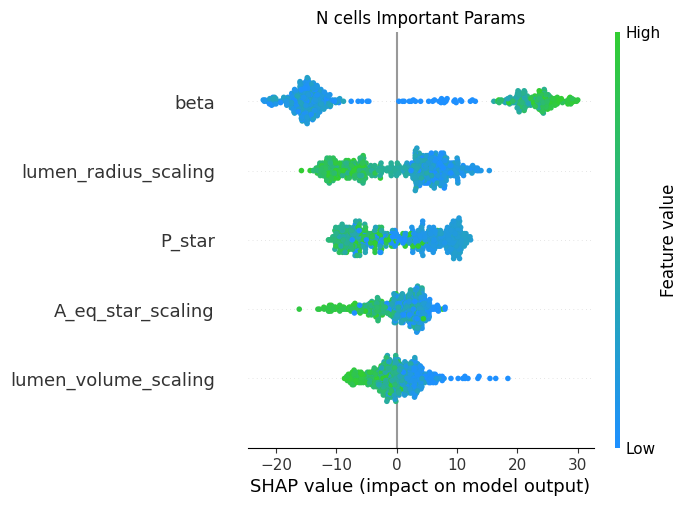

all feature names Index(['beta', 'A_eq_star_scaling', 'lumen_radius_scaling', 'P_star',
       'lumen_volume_scaling'],
      dtype='object')


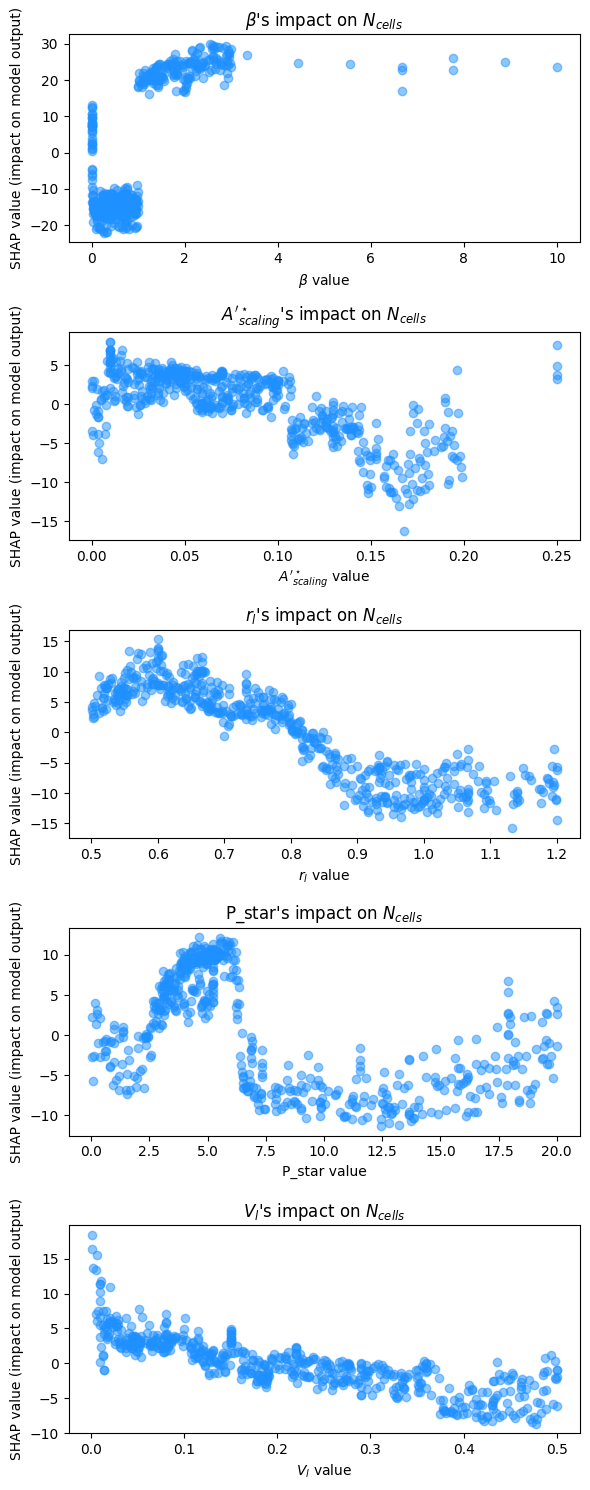

In [70]:
plot_shap_custom("N_cells", X, y)

In [71]:
plot_shap_custom("Sphericity", X, y)

KeyError: 'Sphericity'

# Including Interactions

In [72]:
X, y = output[["beta", "A_eq_star_scaling", "lumen_volume_scaling", "lumen_radius_scaling"]], output[['Cluster_Vol', 'Areas', 't']].rename(columns={'t': 't_max'})# sqrt_features.columns = ['sqrt({})'.format(x) for x in sqrt_features.columns]
original_features = X.columns.tolist()
inverse_features = 1 / X
inverse_features.columns = ['1/{}'.format(x) for x in inverse_features.columns]
X = pd.concat([X, inverse_features], axis=1) # X = input paramaters, y = output results, axis = 1 = stick the columns on the end
for i, feature1 in enumerate(original_features):~
    for feature2 in original_features[i+1:]:
        X[f'{feature1}*{feature2}'] = X[feature1] * X[feature2]
        X[f'{feature1}/{feature2}'] = X[feature1] / X[feature2]
print(X.columns)


SyntaxError: invalid syntax (4121084755.py, line 6)

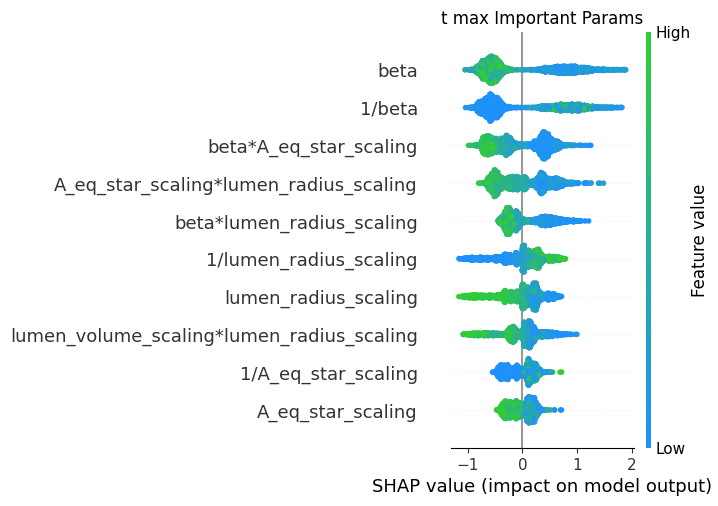

all feature names Index(['beta', 'A_eq_star_scaling', 'lumen_volume_scaling',
       'lumen_radius_scaling', '1/beta', '1/A_eq_star_scaling',
       '1/lumen_volume_scaling', '1/lumen_radius_scaling',
       'beta*A_eq_star_scaling', 'beta/A_eq_star_scaling',
       'beta*lumen_volume_scaling', 'beta/lumen_volume_scaling',
       'beta*lumen_radius_scaling', 'beta/lumen_radius_scaling',
       'A_eq_star_scaling*lumen_volume_scaling',
       'A_eq_star_scaling/lumen_volume_scaling',
       'A_eq_star_scaling*lumen_radius_scaling',
       'A_eq_star_scaling/lumen_radius_scaling',
       'lumen_volume_scaling*lumen_radius_scaling',
       'lumen_volume_scaling/lumen_radius_scaling'],
      dtype='object')


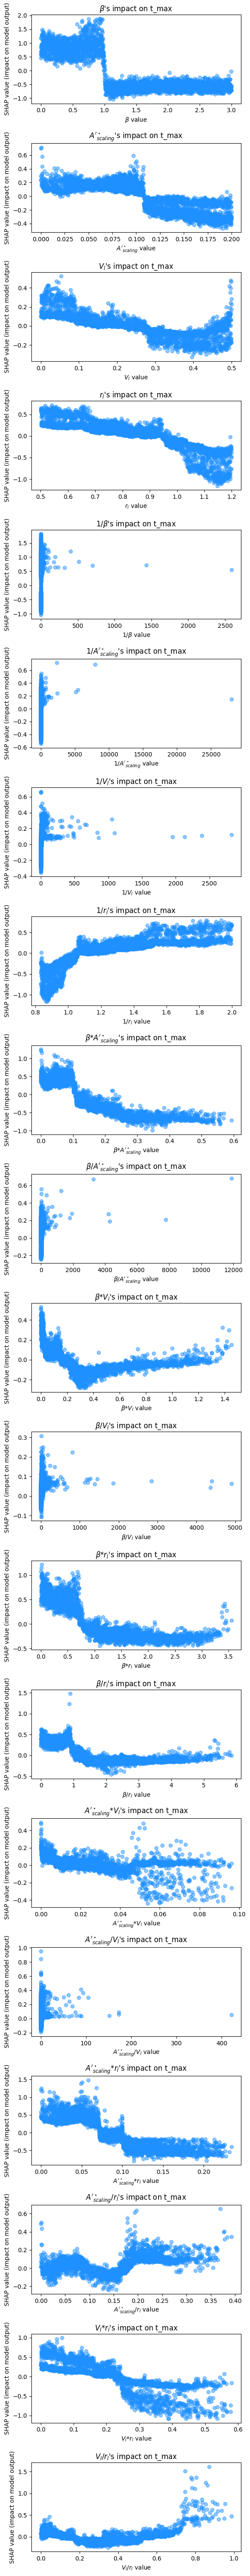

In [28]:
plot_shap_custom("t_max", X, y)

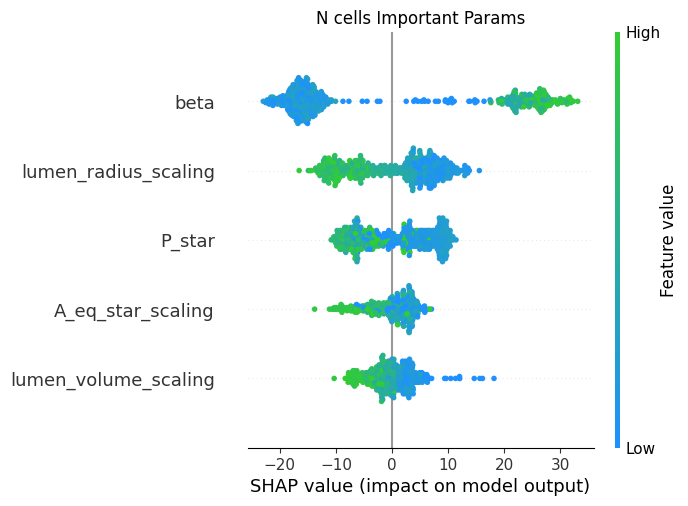

all feature names Index(['beta', 'A_eq_star_scaling', 'lumen_radius_scaling', 'P_star',
       'lumen_volume_scaling'],
      dtype='object')


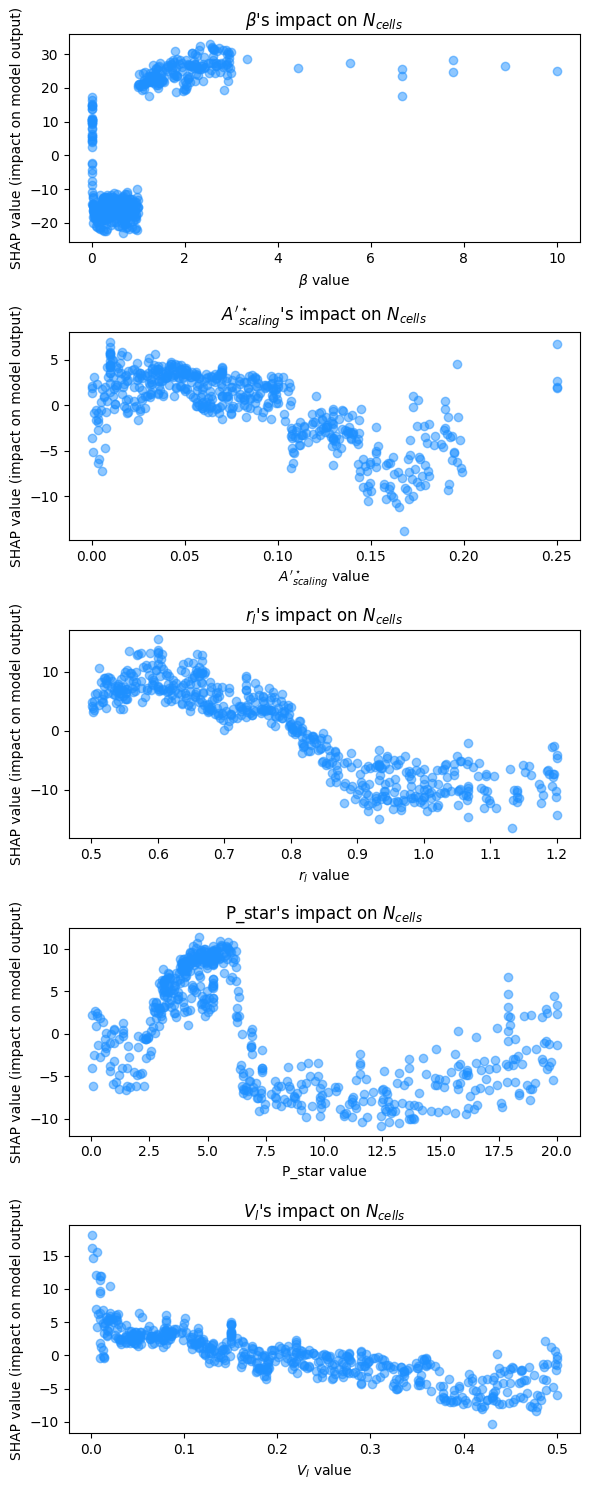

In [73]:
plot_shap_custom("N_cells", X, y)

In [71]:
model = RandomForestRegressor(max_depth=6, n_jobs=-1, n_estimators=500, max_features=0.33)
model.fit(X, y['t_max']);

In [54]:
pd.DataFrame(zip(X.columns, model.feature_importances_), columns=['Feature', 'Importance']).sort_values('Importance', ascending=False).sort_values('Importance', ascending=False)[:10]

,Feature,Importance
173,sqrt(Stiffness) 1/sqrt(De),0.148964
103,Stiffness 1/De,0.146726
88,De 1/Stiffness,0.137142
163,sqrt(De) 1/sqrt(Stiffness),0.115622
29,BM_Spring_Const sqrt(Stiffness),0.049286
184,1/BM_Spring_Const 1/sqrt(Stiffness),0.044823
168,sqrt(Stiffness) 1/De,0.024999
154,sqrt(De) 1/BM_Spring_Const,0.024721
93,De 1/sqrt(Stiffness),0.023791
38,BM_Spring_Const 1/sqrt(De),0.022395


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


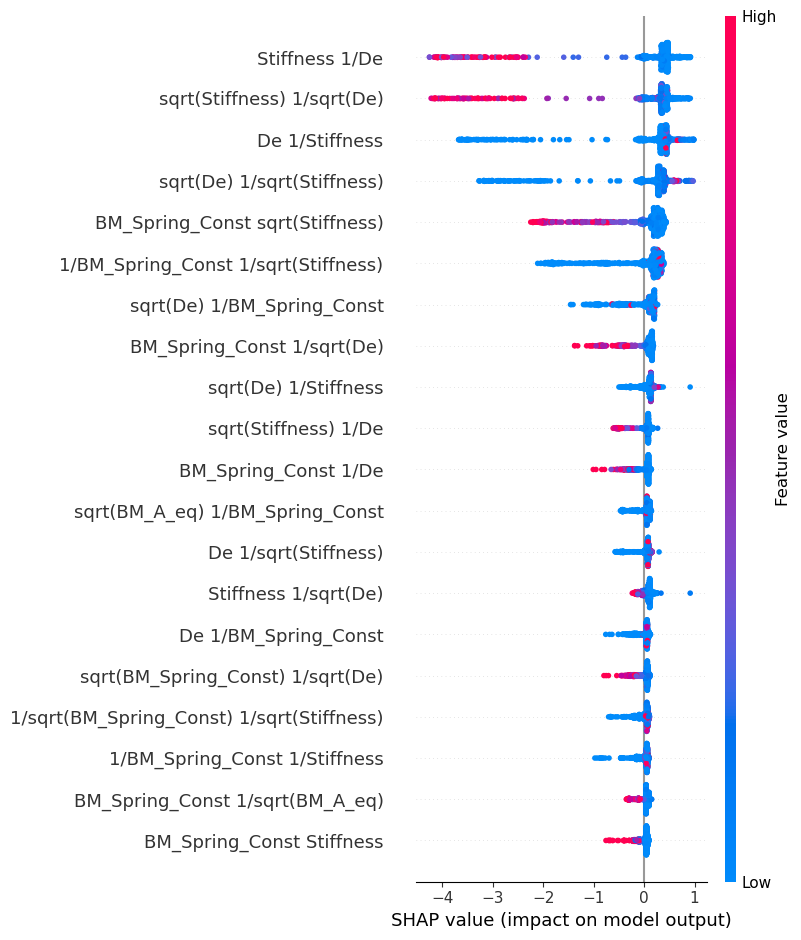

In [55]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)
# Low value of De/stiffness (blue) increases the likelihood of short finish time

In [56]:
model = RandomForestRegressor(max_depth=6, n_jobs=-1, n_estimators=500, max_features=0.33)
model.fit(X, y['Areas']);

In [57]:
pd.DataFrame(zip(X.columns, model.feature_importances_), columns=['Feature', 'Importance']).sort_values('Importance', ascending=False).sort_values('Importance', ascending=False)[:10]

,Feature,Importance
118,sqrt(BM_Spring_Const) 1/De,0.060316
89,De 1/sqrt(BM_Spring_Const),0.051385
38,BM_Spring_Const 1/sqrt(De),0.022787
123,sqrt(BM_Spring_Const) 1/sqrt(De),0.020625
154,sqrt(De) 1/BM_Spring_Const,0.020444
75,Inner_Pressure 1/sqrt(De),0.020067
84,De 1/BM_Spring_Const,0.019412
36,BM_Spring_Const 1/sqrt(BM_A_eq),0.018645
33,BM_Spring_Const 1/De,0.018020
121,sqrt(BM_Spring_Const) 1/sqrt(BM_A_eq),0.016605


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


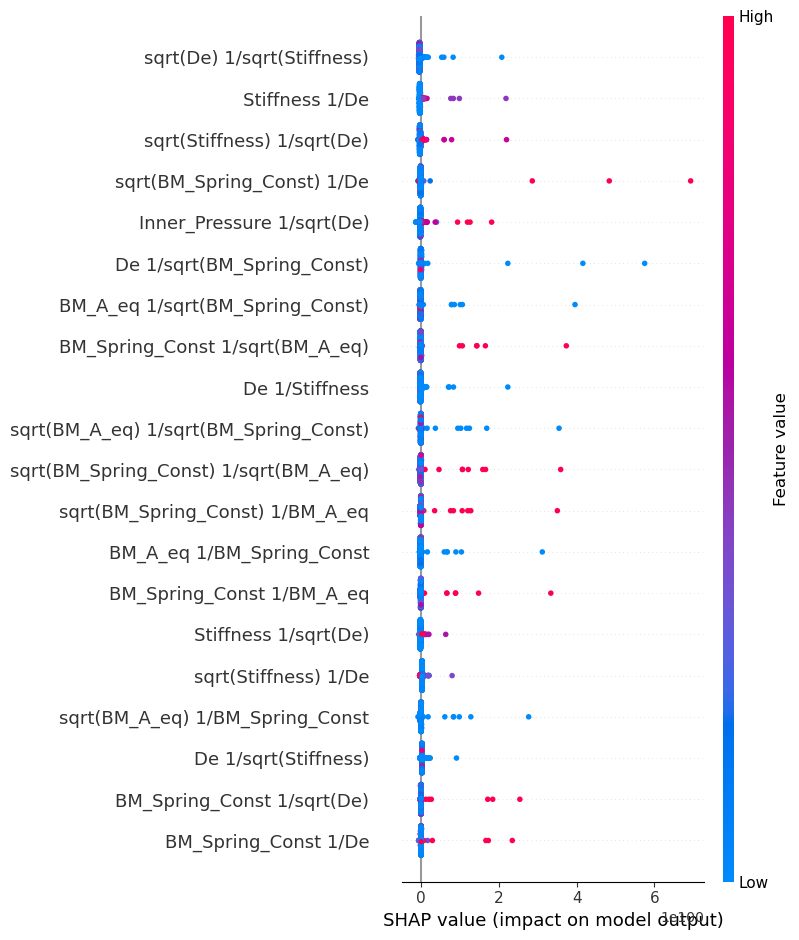

In [58]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)
# Higher values (more red) of BM spring const/BM Aeq lead to higher values (more right) of area
# Lower valeus of De/BM_spring_const = higher values of area
# Lower values of BM A_eq/BM spring_const = lower values of area


In [17]:
shap.dependence_plot("Areas", )